In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integ
import scipy
from scipy.optimize import fsolve#
import math
from tqdm import tqdm

#for 1M star
Msol = 1.99E30
Lsol = 3.846E26
Pcore=4e15
Tcore=2.9e7

#Fixed values and constants 1M
X=0.7
Y=0.27
Z=0.02
X_CN=0.01

#constants-ish
mu=1/(2*X+(Y)*(3/4)+(Z/2))
G=6.67e-11
sig=5.67e-8
c=3e8
a=(4*sig)/(c)
mh=1.67e-27
k=1.38e-23
gam=5/3
#not sure about this lol gam=3/5

#other useful variables
#density gonna be important
def rho(P,T):
    return ((mu*mh)*(P-(1/3)*a*(T**4)))/(k*T)

def density(P,T):
    return ((mu*mh)*(P-(1/3)*a*(T**4)))/(k*T)
#opacity
def kap(rho,T):
    return (3e21)*Z*(1+X)*rho*(T**(-3.5))+0.02*(1+X)

#pp tau
def t_pp(T):
    return 33.80*((T/(10**6))**(-1/3).real)
#CNO tau
def t_CNO(T):
    return 152.3*((T/(10**6))**(-1/3).real)

# maybe both CNO and pp
def ep(rho,T):
    if T > 0:
        return X*rho*(0.00212*X*(t_pp(T)**2)*np.exp(-t_pp(T))+(3.7e16)*X_CN*(t_CNO(T)**2)*np.exp(-t_CNO(T)))
    else:
        return 0

#Stellar Structure Equations
def dP_r(r,M_r,rho):
    return -G*(M_r*rho/r**2)

def dM_r(r,rho):
    return 4*np.pi*(r**2)*rho

def dL_r(r,rho,ep):
    return 4*np.pi*(r**2)*rho*ep

def dT_r(r,rho,M_r,L_r,T,P):
    if dP_r(r,M_r,rho)*(T/P)*(1-(1/gam))>=(-(1-(1/(gam)))*((mu*mh)/(k))*((G*M_r)/(r**2))).real:
        return -(1-(1/(gam)))*((mu*mh)/(k))*((G*M_r)/(r**2)).real
    else:
        return -((3)/(4*a*c))*((kap(rho,T))*(rho)/T**3)*((L_r)/(4*np.pi*r**2))

In [10]:
h = 1000
Pressue_initial = 3.3 * 10**15
Temperature_initial = 1.075 * 10**7
pressure = Pressue_initial
temperature = Temperature_initial
luminosity = 0
mass = 0
radius = 0

radius_list = [0.0]
pressure_list = [pressure]
temperature_list = [temperature]
luminosity_list = [luminosity]
mass_list = [mass]

from tqdm import tqdm

for i in tqdm(range(1, 1000000)):
    if temperature.real < 0 or pressure.real < 0 or rho(pressure, temperature).real < 0:
        radius_list.pop()
        pressure_list.pop()
        temperature_list.pop()
        luminosity_list.pop()
        mass_list.pop()
        break

    radius += h
    radius_list.append(radius)

    p1 = h * dP_r(radius, rho(pressure, temperature), mass)
    p2 = h * dP_r(radius + h / 2, rho(pressure + p1 / 2, temperature), mass)
    p3 = h * dP_r(radius + h / 2, rho(pressure + p2 / 2, temperature), mass)
    p4 = h * dP_r(radius + h, rho(pressure + p3, temperature), mass)

    m1 = h * dM_r(radius, rho(pressure, temperature))
    m2 = h * dM_r(radius + h / 2, rho(pressure, temperature))
    m3 = h * dM_r(radius + h / 2, rho(pressure, temperature))
    m4 = h * dM_r(radius + h, rho(pressure, temperature))

    l1 = h * dL_r(radius, rho(pressure, temperature), ep(rho(pressure, temperature), temperature))
    l2 = h * dL_r(radius + h / 2, rho(pressure, temperature), ep(rho(pressure, temperature), temperature))
    l3 = h * dL_r(radius + h / 2, rho(pressure, temperature), ep(rho(pressure, temperature), temperature))
    l4 = h * dL_r(radius + h, rho(pressure, temperature), ep(rho(pressure, temperature), temperature))

    t1 = h * dT_r(radius, kap(rho(pressure, temperature), temperature), rho(pressure, temperature), temperature, luminosity)
    t2 = h * dT_r(radius + h / 2, kap(rho(pressure, temperature + t1 / 2), temperature + t1 / 2), rho(pressure, temperature + t1 / 2), temperature + t1 / 2, luminosity)
    t3 = h * dT_r(radius + h / 2, kap(rho(pressure, temperature + t2 / 2), temperature + t2 / 2), rho(pressure, temperature + t2 / 2), temperature + t2 / 2, luminosity)
    t4 = h * dT_r(radius + h, kap(rho(pressure, temperature + t3), temperature + t3), rho(pressure, temperature + t3), temperature + t3, luminosity)

    temperature += (t1 / 6) + (t2 / 3) + (t3 / 3) + (t4 / 6)
    mass += (m1 / 6) + (m2 / 3) + (m3 / 3) + (m4 / 6)
    pressure += (p1 / 6) + (p2 / 3) + (p3 / 3) + (p4 / 6)
    luminosity += (l1 / 6) + (l2 / 3) + (l3 / 3) + (l4 / 6)

    pressure_list.append(pressure)
    temperature_list.append(temperature)
    mass_list.append(mass)
    luminosity_list.append(luminosity)

import matplotlib.pyplot as plt

plt.plot(radius_list, mass_list, label='Mass')
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.title('Mass vs Radius')
plt.legend()
plt.show()

plt.plot(radius_list, pressure_list, label='Pressure')
plt.xlabel('Radius')
plt.ylabel('Pressure')
plt.title('Pressure vs Radius')
plt.legend()
plt.show()

plt.plot(radius_list, temperature_list, label='Temperature')
plt.xlabel('Radius')
plt.ylabel('Temperature')
plt.title('Temperature vs Radius')
plt.legend()
plt.show()

plt.plot(radius_list, luminosity_list, label='Luminosity')
plt.xlabel('Radius')
plt.ylabel('Luminosity')
plt.title('Luminosity vs Radius')
plt.legend()
plt.show()


  0%|          | 0/999999 [00:00<?, ?it/s]


TypeError: dT_r() missing 1 required positional argument: 'P'

In [11]:

plt.plot(Radius_values,Mass_values,label='M_r')
plt.xlabel('Radius (m)')
plt.ylabel('M_r')
plt.title('M_r vs. Radius')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Radius_values,P_values,label='P_r')
plt.xlabel('Radius (m)')
plt.ylabel('P_r')
plt.title('P_r vs. Radius')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Radius_values,T_values,label='T_r')
plt.xlabel('Radius (m)')
plt.ylabel('T_r')
plt.title('T_r vs. Radius')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Radius_values,Lum_values,label='L_r')
plt.xlabel('Radius (m)')
plt.ylabel('L_r')
plt.title('L_r vs. Radius')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'Radius_values' is not defined

 50%|████▉     | 497443/999999 [00:16<00:16, 30665.28it/s]


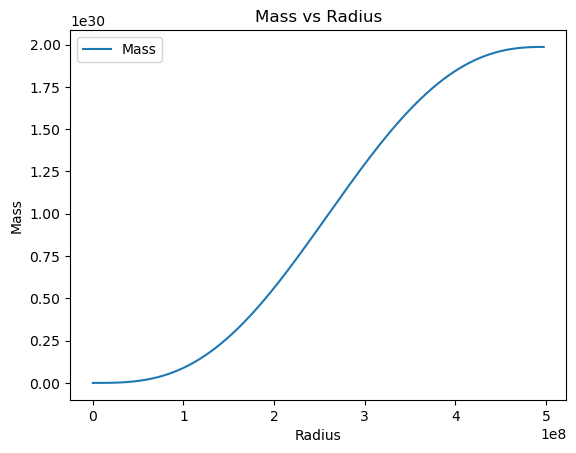

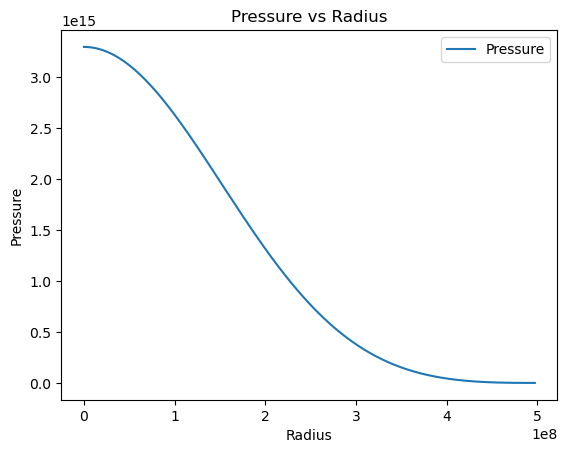

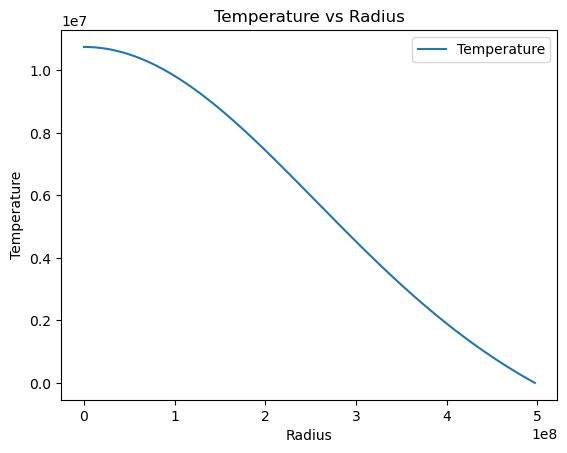

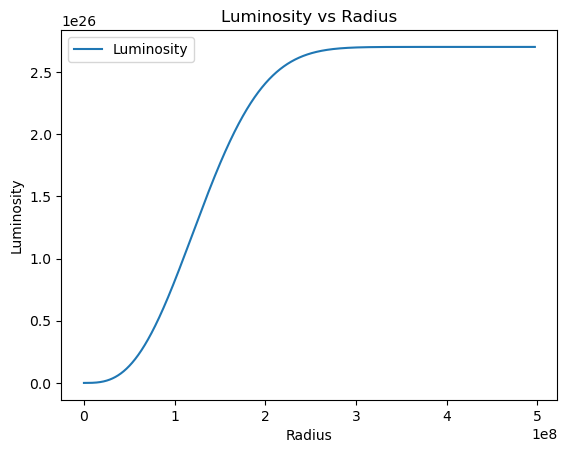

In [13]:
h = 1000
Pressue_initial = 3.3 * 10**15
Temperature_initial = 1.075 * 10**7
pressure = Pressue_initial
temperature = Temperature_initial
luminosity = 0
mass = 0
radius = 0

radius_list = [0.0]
pressure_list = [pressure]
temperature_list = [temperature]
luminosity_list = [luminosity]
mass_list = [mass]

from tqdm import tqdm

for i in tqdm(range(1, 1000000)):
    if temperature.real < 0 or pressure.real < 0 or density(pressure, temperature).real < 0:
        radius_list.pop()
        pressure_list.pop()
        temperature_list.pop()
        luminosity_list.pop()
        mass_list.pop()
        break

    radius += h
    radius_list.append(radius)

    Pk1 = h * dP_r(radius, density(pressure, temperature), mass)
    Pk2 = h * dP_r(radius + h / 2, density(pressure + Pk1 / 2, temperature), mass)
    Pk3 = h * dP_r(radius + h / 2, density(pressure + Pk2 / 2, temperature), mass)
    Pk4 = h * dP_r(radius + h, density(pressure + Pk3, temperature), mass)

    Tk1 = h * dT_r(radius, density(pressure, temperature), mass, luminosity, temperature, pressure)
    Tk2 = h * dT_r(radius + h / 2, density(pressure, temperature + Tk1 / 2), mass, luminosity, temperature + Tk1 / 2, pressure)
    Tk3 = h * dT_r(radius + h / 2, density(pressure, temperature + Tk2 / 2), mass, luminosity, temperature + Tk2 / 2, pressure)
    Tk4 = h * dT_r(radius + h, density(pressure, temperature + Tk3), mass, luminosity, temperature + Tk3, pressure)

    k1 = h * dM_r(radius, density(pressure, temperature))
    k2 = h * dM_r(radius + h / 2, density(pressure, temperature))
    k3 = h * dM_r(radius + h / 2, density(pressure, temperature))
    k4 = h * dM_r(radius + h, density(pressure, temperature))

    Lk1 = h * dL_r(radius, density(pressure, temperature), ep(density(pressure, temperature), temperature))
    Lk2 = h * dL_r(radius + h / 2, density(pressure, temperature), ep(density(pressure, temperature), temperature))
    Lk3 = h * dL_r(radius + h / 2, density(pressure, temperature), ep(density(pressure, temperature), temperature))
    Lk4 = h * dL_r(radius + h, density(pressure, temperature), ep(density(pressure, temperature), temperature))

    temperature = temperature + Tk1 / 6 + Tk2 / 3 + Tk3 / 3 + Tk4 / 6
    temperature_list.append(temperature)

    mass = mass + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
    mass_list.append(mass)

    luminosity = luminosity + Lk1 / 6 + Lk2 / 3 + Lk3 / 3 + Lk4 / 6
    luminosity_list.append(luminosity)

    pressure = pressure + Pk1 / 6 + Pk2 / 3 + Pk3 / 3 + Pk4 / 6
    pressure_list.append(pressure)

import matplotlib.pyplot as plt

plt.plot(radius_list, mass_list, label='Mass')
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.title('Mass vs Radius')
plt.legend()
plt.show()

plt.plot(radius_list, pressure_list, label='Pressure')
plt.xlabel('Radius')
plt.ylabel('Pressure')
plt.title('Pressure vs Radius')
plt.legend()
plt.show()

plt.plot(radius_list, temperature_list, label='Temperature')
plt.xlabel('Radius')
plt.ylabel('Temperature')
plt.title('Temperature vs Radius')
plt.legend()
plt.show()

plt.plot(radius_list, luminosity_list, label='Luminosity')
plt.xlabel('Radius')
plt.ylabel('Luminosity')
plt.title('Luminosity vs Radius')
plt.legend()
plt.show()
